# Hyperparameter Optimization using Optuna

To automatically tune hyperparameters in a ML model, we can use hyperparameter optimization (HPO) algorithms such as Tree-structured Parzen estimators (TPE) and genetic programming. In this tutorial we will use `optuna`, a very popular HPO library implementing TPE.

![image.png](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*AZQ02wkfEBN9uqy4p3a28w.gif)

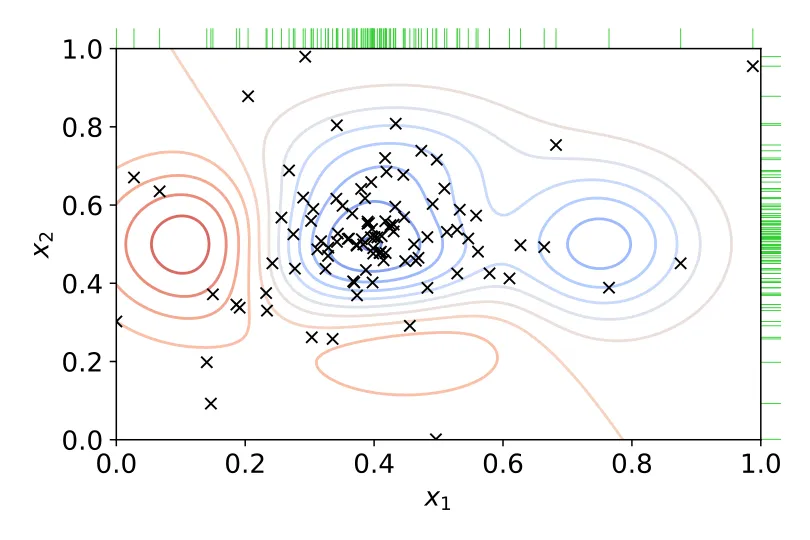

In [1]:
%%capture%pip install -U fastai optuna optuna-integration plotly nbformat

## Define the Objective

In [21]:
import warnings
warnings.filterwarnings("ignore")

import optuna
from optuna.integration import FastAIPruningCallback
from fastai.vision.all import accuracy, ImageDataLoaders, Learner, SimpleCNN, untar_data, URLs


BATCHSIZE = 256
EPOCHS = 6
PATH = untar_data(URLs.MNIST_TINY)

data = ImageDataLoaders.from_folder(
    PATH, bs=BATCHSIZE
)

def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)

    n_channels = [3]
    for i in range(n_layers):
        out_channels = trial.suggest_int("n_channels_{}".format(i), 3, 8)
        n_channels.append(out_channels)
    n_channels.append(2)

    model = SimpleCNN(n_channels)

    learn = Learner(
        data,
        model,
        lr=trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        metrics=[accuracy],
        cbs=FastAIPruningCallback(trial, monitor="accuracy"),
    )

    # disable progress bar and logging info
    with learn.no_bar():
        with learn.no_logging():
            learn.fit(EPOCHS)

    return learn.recorder.metrics[0].value.item()

## Create an Optuna study and optimize the hyperparameters

In [3]:
pruning = True

pruner = optuna.pruners.MedianPruner() if pruning else optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=30, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-07 11:13:24,241] A new study created in memory with name: no-name-1cb47a56-38d3-4935-ac9c-dbe3013b4d46
[I 2024-03-07 11:13:37,246] Trial 0 finished with value: 0.36623749136924744 and parameters: {'n_layers': 3, 'n_channels_0': 5, 'n_channels_1': 4, 'n_channels_2': 7, 'lr': 0.0005776105329171271}. Best is trial 0 with value: 0.36623749136924744.
[I 2024-03-07 11:13:49,693] Trial 1 finished with value: 0.49499285221099854 and parameters: {'n_layers': 1, 'n_channels_0': 8, 'lr': 0.0020008459536636747}. Best is trial 1 with value: 0.49499285221099854.
[I 2024-03-07 11:14:02,855] Trial 2 finished with value: 0.8311874270439148 and parameters: {'n_layers': 1, 'n_channels_0': 5, 'lr': 0.005902443823200275}. Best is trial 2 with value: 0.8311874270439148.
[I 2024-03-07 11:14:15,369] Trial 3 finished with value: 0.5050071477890015 and parameters: {'n_layers': 2, 'n_channels_0': 5, 'n_channels_1': 4, 'lr': 0.0010951917884913993}. Best is trial 2 with value: 0.8311874270439148.
[I 202

Number of finished trials: 30
Best trial:
  Value: 0.9642346501350403
  Params: 
    n_layers: 2
    n_channels_0: 3
    n_channels_1: 8
    lr: 0.006190964435629972


# Evaluate the Performance

In [10]:
n_channels = [3] + [trial.params["n_channels_{}".format(i)] for i in range(trial.params["n_layers"])] + [2]
best_model = SimpleCNN(n_channels)
learner = Learner(
    data,
    best_model,
    lr=trial.params["lr"],
    metrics=[accuracy],
)
learner.fit(EPOCHS)

epoch,train_loss,valid_loss,accuracy,time
0,0.680224,0.672850,0.626609,00:01
1,0.659778,0.644037,0.783977,00:01
2,0.639163,0.599324,0.885551,00:02
3,0.617785,0.542808,0.937053,00:02
4,0.594801,0.482140,0.952790,00:02
5,0.571569,0.419622,0.961373,00:02


In [11]:
preds, targs, loss = learner.get_preds(with_loss=True)
accuracy(preds, targs)

TensorBase(0.9614)

## Visualize the study

In [12]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

plot_optimization_history(study)

In [13]:
# Visualize high-dimensional parameter relationships. 
plot_parallel_coordinate(study)

In [15]:
# Visualize hyperparameter relationships.
fig = plot_contour(study)
fig.update_layout(width=800, height=800)

In [16]:
# Visualize individual hyperparameters as slice plot.
plot_slice(study)

In [17]:
# Visualize parameter importances.
plot_param_importances(study)

## Congratulations!

Congratulations on completing this notebook tutorial!